In [7]:
import os
import sys
import scipy
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import numpy as np
import pprint

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:461: FutureWarning: Passing (type, 1) or 

In [8]:
def load_vgg_model(path):
  vgg = scipy.io.loadmat(path)
  vgg_layers = vgg["layers"]

  def _weights(layer, expected_layer_name):
    wb = vgg_layers[0][layer][0][0][2]
    W = wb[0][0]
    b = wb[0][1]
    return W, b

  def _relu(conv2d_layer):
    return tf.nn.relu(conv2d_layer)

  def _conv2d(prev_layer, layer, layer_name):
    W, b = _weights(layer, layer_name)
    W = tf.constant(W)
    b = tf.nn.conv2d(prev_layer, filter=W, strides=[1, 1, 1, 1], padding="SAME")+ b

  def _conv2d_relu(prev_layer, layer, layer_name):
    return _relu(_conv2d(prev_layer, layer_layer_name))

  def _avgpool(prev_layer):
    return tf.nn.avg_pool(prev_layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1],
                          padding="SAME")
  
  # Constructs the graph model.
  graph = {}
  graph['input']   = tf.Variable(np.zeros((1, CONFIG.IMAGE_HEIGHT, CONFIG.IMAGE_WIDTH, CONFIG.COLOR_CHANNELS)), dtype = 'float32')
  graph['conv1_1']  = _conv2d_relu(graph['input'], 0, 'conv1_1')
  graph['conv1_2']  = _conv2d_relu(graph['conv1_1'], 2, 'conv1_2')
  graph['avgpool1'] = _avgpool(graph['conv1_2'])
  graph['conv2_1']  = _conv2d_relu(graph['avgpool1'], 5, 'conv2_1')
  graph['conv2_2']  = _conv2d_relu(graph['conv2_1'], 7, 'conv2_2')
  graph['avgpool2'] = _avgpool(graph['conv2_2'])
  graph['conv3_1']  = _conv2d_relu(graph['avgpool2'], 10, 'conv3_1')
  graph['conv3_2']  = _conv2d_relu(graph['conv3_1'], 12, 'conv3_2')
  graph['conv3_3']  = _conv2d_relu(graph['conv3_2'], 14, 'conv3_3')
  graph['conv3_4']  = _conv2d_relu(graph['conv3_3'], 16, 'conv3_4')
  graph['avgpool3'] = _avgpool(graph['conv3_4'])
  graph['conv4_1']  = _conv2d_relu(graph['avgpool3'], 19, 'conv4_1')
  graph['conv4_2']  = _conv2d_relu(graph['conv4_1'], 21, 'conv4_2')
  graph['conv4_3']  = _conv2d_relu(graph['conv4_2'], 23, 'conv4_3')
  graph['conv4_4']  = _conv2d_relu(graph['conv4_3'], 25, 'conv4_4')
  graph['avgpool4'] = _avgpool(graph['conv4_4'])
  graph['conv5_1']  = _conv2d_relu(graph['avgpool4'], 28, 'conv5_1')
  graph['conv5_2']  = _conv2d_relu(graph['conv5_1'], 30, 'conv5_2')
  graph['conv5_3']  = _conv2d_relu(graph['conv5_2'], 32, 'conv5_3')
  graph['conv5_4']  = _conv2d_relu(graph['conv5_3'], 34, 'conv5_4')
  graph['avgpool5'] = _avgpool(graph['conv5_4'])

  return graph


In [33]:
pp = pprint.PrettyPrinter(indent=4)
model = load_vgg_model("/content/imagenet-vgg-verydeep-19.mat")
pp.print(model)

OSError: ignored

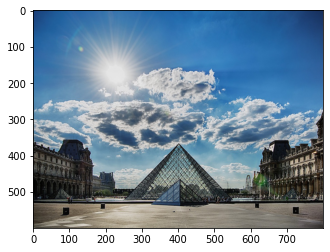

In [10]:
img = scipy.misc.imread("/content/louvre.jpg")
plt.imshow(img)

In [13]:
def compute_content_cost(a_C, a_G):
  m, n_H, n_W, n_C = a_G.get_shape().as_list()

  a_C_unrolled = tf.reshape(tf.transpose(a_C), shape=[n_C, n_H * n_W])
  a_G_unrolled = tf.reshape(tf.transpose(a_G), shape=[n_C, n_H * n_W])

  J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(
      tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))
  
  return J_content

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.765592


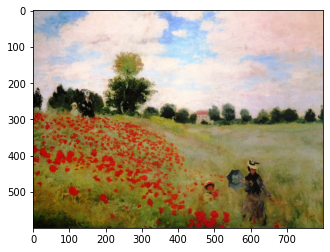

In [17]:
style_img = scipy.misc.imread("/content/monet.jpg")
plt.imshow(style_img)

In [18]:
def gram_matrix(A):
  GA = tf.matmul(A, tf.transpose(A))
  return GA

In [19]:
tf.reset_default_graph()

with tf.Session() as test:
  A = tf.random_normal([3, 2], mean=1, stddev=4)
  GA = gram_matrix(A)

  print("GA = \n" + str(GA.eval()))

GA = 
[[24.147568 30.971909 10.745581]
 [30.971909 39.734375 14.651667]
 [10.745581 14.651667 84.33738 ]]


In [20]:
def compute_layer_style_cost(a_S, a_G):
  m, n_H, n_W, n_C = a_G.get_shape().as_list()

  a_S = tf.reshape(tf.transpose(a_S), shape=[n_C, n_H*n_W])
  a_G = tf.reshape(tf.transpose(a_G), shape=[n_C, n_H*n_W])

  GS = gram_matrix(a_S)
  GG = gram_matrix(a_G)

  J_style_layer = (1 / (4 * n_C ** 2 * n_H ** 2 * n_W ** 2)) * tf.reduce_sum(
                  tf.square(tf.subtract(GS, GG)))
  
  return J_style_layer

In [21]:
tf.reset_default_graph()

with tf.Session() as test:
  a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
  a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
  J_style_layer = compute_layer_style_cost(a_S, a_G)

  print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 8.594493


In [22]:
STYLE_LAYERS = [
                ("conv1_1", 0.2),
                ("conv2_1", 0.2),
                ("conv3_1", 0.2),
                ("conv4_1", 0.2),
                ("conv5_1", 0.2)]

In [23]:
def compute_style_cost(model, STYLE_LAYERS):
  J_style = 0
  for layer_name, coeff in STYLE_LAYERS:
    out = model[layer_name]
    a_S = sess.run(out)
    a_G = out

    J_style_layer = compute_layer_style_cost(a_S, a_G)

    J_style += coeff * J_style_layer
    
  return J_style

In [24]:
def total_cost(J_content, J_style, alpha=10, beta=40):
  J = (alpha * J_content) + (beta * J_style)

  return J

In [26]:
tf.reset_default_graph()

with tf.Session() as test:
  J_content = np.random.randn()
  J_style = np.random.randn()
  J = total_cost(J_content, J_style)
  print("J = " + str(J))

J = -28.257558747134897


In [27]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

In [28]:
def reshape_and_normalize_img(img):
  img = np.reshape(img, ((1,) + img.shape))
  mean = np.array([123.68, 116.779, 103.939]).reshape((1,1,1,3))
  img = img - mean
  return img

In [29]:
img = scipy.misc.imread("/content/louvre_small.jpg")
img = reshape_and_normalize_img(img)

In [31]:
style_img = scipy.misc.imread("/content/monet_small.jpg")
style_img = reshape_and_normalize_img(style_img)

In [32]:
def generate_noise_img(img, noise_ratio= 0.6):
  noise_img = np.random.uniform(-20, 20, (1, 300, 400, 3)).astype("float32")

  input_img = noise_img * noise_ratio + img * (1 - noise_ratio)

  return input_img

In [ ]:
generated_img = generate_noise_img(img)
plt.imshow(generated_img[0])

In [34]:
sess.run(model["input"].assign(img))

out = mdel["conv4_2"]

a_C = sess.run(out)

a_G = out

J_content = compute_content_cost(a_C, a_G)

NameError: ignored

In [ ]:
sess.run(model["input"].assing(style_img))

J_style = compute_style_cost(model, STYLE_LAYERS)

In [ ]:
J = total_cost(J_content, J_style, alpha=10, beta=40)

In [ ]:
optimizer = tf.train.AdamOptimizer(2.0)

train_step = optimizer.minimize(J)

In [ ]:
def model_nn(sess, input_img, num_iters=200):
  sess.run(tf.global_variables_initializer())

  sess.run(model["input"].assign(input_img))

  for i in range(num_iters):
    sess.run(train_step)

    generated_img = sess.run(model["input"])

    if i % 20 == 0:
      Jt, Jc, Js = sess.run([J, J_content, J_style])
      print("Iteration " + str(i) + " :")
      print("total cost = " + str(Jt))
      print("content cost = " + str(Jc))
      print("style cost = " + str(Js))

      save_img("images/" + str(i) + ".png", generated_img)
  save_img('images/generated_image.jpg', generated_img)
  return generated_img

In [ ]:
model_nn(sess, generated_img)